## The data was acquired from "MovieLens" and it contains 27,000,000 ratings and 1,100,000 tag applications applied to 58,000 movies by 280,000 users

### In this project I implemented Collaborative Filtering to create a recommendation system for movies

### Using Google Colab- Mounting drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#Change working directory
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")
os.getcwd() 

'/content/gdrive/My Drive/Colab Notebooks'

### Import Libraries

In [0]:
import numpy as np  
import pandas as pd

### Data exploration

In [4]:
ratings_data = pd.read_csv("Recommendation/small/ratings.csv")  
ratings_data.head()  

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
#Notive that there is a problem with this dataset: it contains the IDs of the movies but not their titles. 
#The movie names for the movies we're recommending are in a different file called movies.csv. 

movie_names = pd.read_csv("Recommendation/small/movies.csv")  
movie_names.head() 

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Merging both datasets based on movieID


In [6]:
movie_data = pd.merge(ratings_data, movie_names, on='movieId')
movie_data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


### Average rating of each movie


In [7]:
#Group the dataset by the title of the movie and then calculate the mean of the rating for each movie. 
movie_data.groupby('title')['rating'].mean().head()  

title
'71 (2014)                                 4.0
'Hellboy': The Seeds of Creation (2004)    4.0
'Round Midnight (1986)                     3.5
'Salem's Lot (2004)                        5.0
'Til There Was You (1997)                  4.0
Name: rating, dtype: float64

### Sorting the ratings in the descending order of their average ratings:
 

In [8]:
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head()  

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

In [9]:
#Note that there is a problem. A movie can make it to the top of the above list even if only a single user has given it five stars

#Plotting the total number of ratings for a movie:
movie_data.groupby('title')['rating'].count().sort_values(ascending=False).head()  

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [0]:
#The above list supports the point that good movies normally receive higher ratings.
#Now we know that both the average rating per movie and the number of ratings per movie are important attributes.

### Create a new dataframe that contains both of these attributes.
#### First add the average rating of each movie to this dataframe:



In [0]:
ratings_mean_count = pd.DataFrame(movie_data.groupby('title')['rating'].mean())  

### Add the number of ratings for a movie


In [12]:
ratings_mean_count['rating_counts'] = pd.DataFrame(movie_data.groupby('title')['rating'].count())  
ratings_mean_count.head()  

,rating,rating_counts
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [0]:
#You can see movie title, along with the average rating and number of ratings for the movie.

### Plot a histogram for the number of ratings represented by the "rating_counts" column 


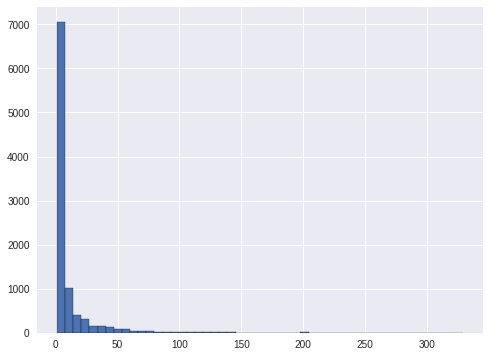

In [14]:

import matplotlib.pyplot as plt  
import seaborn as sns  
sns.set_style('dark')  
%matplotlib inline

plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating_counts'].hist(bins=50)

In [0]:
#most of the movies have received less than 50 ratings

### plot a histogram for average ratings

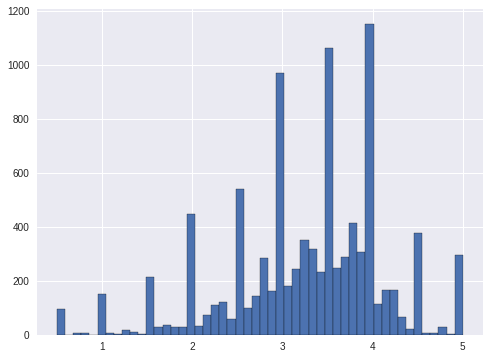

In [16]:
plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
ratings_mean_count['rating'].hist(bins=50)

In [0]:
#You can see that the integer values have taller bars than the floating values since most of the users assign rating as integer value i.e. 1, 2, 3, 4 or 5.
#It is evident that the data has a weak normal distribution.
#Also note that there are a few outliers in the data.

### Checking if movies with a higher number of ratings have a high average rating as well 


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


<Figure size 576x432 with 0 Axes>

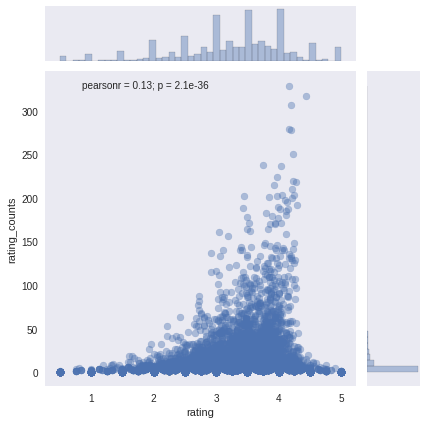

In [18]:
#We will plot average ratings against the number of ratings
plt.figure(figsize=(8,6))  
plt.rcParams['patch.force_edgecolor'] = True  
sns.jointplot(x='rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

In [0]:
#The graph shows that, in general, movies with higher average ratings actually have ratings, compared with movies that have a lower average ratings.

### Finding Similarities Between Movies

In [20]:
#Using the correlation between the ratings of a movie as the similarity metric.
#To find the correlation between the ratings of the movie, we need to create a matrix where each column is a movie name and each row contains the rating assigned by a specific user to that movie.
#Note that this matrix will have a lot of null values since every movie is not rated by every user.
#Each column contains all the user ratings for a particular movie.
user_movie_rating = movie_data.pivot_table(index='userId', columns='title', values='rating')  
user_movie_rating.head()  

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Finding all the user ratings for the movie "Forrest Gump (1994)"" and finding the movies similar to it


In [21]:
#We chose this movie since it has the highest number of ratings and we want to find the correlation between movies that have a higher number of ratings.
forrest_gump_ratings = user_movie_rating['Forrest Gump (1994)']  
forrest_gump_ratings.head()  

userId
1    4.0
2    NaN
3    NaN
4    NaN
5    NaN
Name: Forrest Gump (1994), dtype: float64

In [22]:
#Now let's retrieve all the movies that are similar to "Forrest Gump (1994)".
#We can find the correlation between the user ratings for the "Forest Gump (1994)" and all the other movies using corrwith()
movies_like_forest_gump = user_movie_rating.corrwith(forrest_gump_ratings)

corr_forrest_gump = pd.DataFrame(movies_like_forest_gump, columns=['Correlation'])  
corr_forrest_gump.dropna(inplace=True)  
corr_forrest_gump.head() 

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,Correlation
title,
"'burbs, The (1989)",0.197712
(500) Days of Summer (2009),0.234095
*batteries not included (1987),0.892710
...And Justice for All (1979),0.928571
10 Cent Pistol (2015),-1.000000


In [23]:
#Above, We first retrieved the list of all the movies related to "Forrest Gump (1994)" along with their correlation value, using corrwith() function. 
#Next, we created a dataframe that contains movie title and correlation columns. We then removed all the NA values from the dataframe and displayed its first 5 rows using the head function.
#Sorting the movies in descending order of correlation to see highly correlated movies at the top.
corr_forrest_gump.sort_values('Correlation', ascending=False).head(10)  

,Correlation
title,
Lost & Found (1999),1.0
"Century of the Self, The (2002)",1.0
The 5th Wave (2016),1.0
Play Time (a.k.a. Playtime) (1967),1.0
Memories (Memorîzu) (1995),1.0
Playing God (1997),1.0
Killers (2010),1.0
"Girl Walks Home Alone at Night, A (2014)",1.0
Tampopo (1985),1.0


In [24]:
#From the output you can see that movies that have high correlation with "Forrest Gump (1994)" are not very well known.
#This shows that correlation alone is not a good metric for similarity because there can be a user who watched '"Forest Gump (1994)" and only one other movie and rated both of them as 5.
#A solution to this problem is to retrieve only those correlated movies that have at least more than 50 ratings.
#To do so, will add the rating_counts column from the rating_mean_count dataframe to our corr_forrest_gump dataframe.
corr_forrest_gump = corr_forrest_gump.join(ratings_mean_count['rating_counts'])  
corr_forrest_gump.head()

,Correlation,rating_counts
title,,
"'burbs, The (1989)",0.197712,17
(500) Days of Summer (2009),0.234095,42
*batteries not included (1987),0.892710,7
...And Justice for All (1979),0.928571,3
10 Cent Pistol (2015),-1.000000,2


In [25]:
#We can generally say that a movie cannot be declared similar to the another movie based on just 3 ratings. This is why we added "rating_counts" column. 
#Let's now filter movies correlated to "Forest Gump (1994)", that have more than 50 ratings. 
corr_forrest_gump[corr_forrest_gump ['rating_counts']>50].sort_values('Correlation', ascending=False).head()  

,Correlation,rating_counts
title,,
Forrest Gump (1994),1.000000,329
Mr. Holland's Opus (1995),0.652144,80
Pocahontas (1995),0.550118,68
Grumpier Old Men (1995),0.534682,52
Caddyshack (1980),0.520328,52


In [0]:
#Now you can see from the output the movies that are highly correlated with "Forrest Gump (1994)". 